1  Data Preprocessing
 

In [127]:
import pandas as pd

weather = pd.read_csv('weather_data.csv')
print(weather.info())
print(weather.describe())
print(weather.head())
print(weather.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             311 non-null    object 
 1   avg_temperature  296 non-null    float64
 2   humidity         296 non-null    float64
 3   avg_wind_speed   296 non-null    float64
 4   rain_or_not      311 non-null    object 
 5   cloud_cover      296 non-null    float64
 6   pressure         311 non-null    float64
dtypes: float64(5), object(2)
memory usage: 17.1+ KB
None
       avg_temperature    humidity  avg_wind_speed  cloud_cover     pressure
count       296.000000  296.000000      296.000000   296.000000   311.000000
mean         25.983840   55.041385        7.556636    49.834827  1001.059119
std           6.802475   19.220133        5.344683    29.009459    28.835595
min          15.000000   30.000000        0.069480     0.321826   951.240404
25%          20.265692   34.280826     

Handle missing values

In [128]:
weather['avg_temperature'].fillna(weather['avg_temperature'].median(), inplace=True)
weather['humidity'].fillna(weather['humidity'].median(), inplace=True)
weather['avg_wind_speed'].fillna(weather['avg_wind_speed'].median(), inplace=True)

C:\Users\ROG STRIX\AppData\Local\Temp\ipykernel_33784\4286266497.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  weather['avg_temperature'].fillna(weather['avg_temperature'].median(), inplace=True)
C:\Users\ROG STRIX\AppData\Local\Temp\ipykernel_33784\4286266497.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setti

In [129]:
weather['date'] = pd.to_datetime(weather['date'])


#### Extract additional features from date


In [130]:
weather['month'] = weather['date'].dt.month
weather['day'] = weather['date'].dt.day
weather['day_of_week'] = weather['date'].dt.dayofweek

Check for outliers


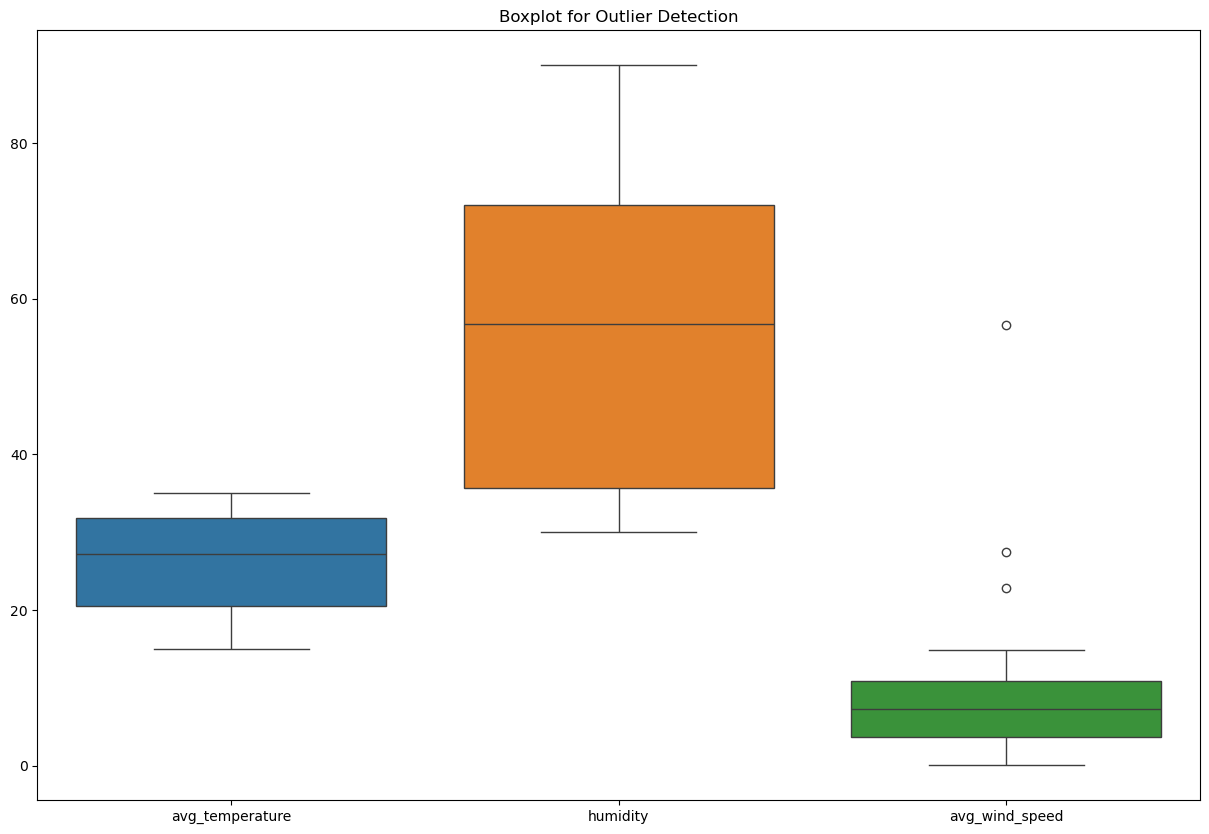

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(15, 10))
sns.boxplot(data=weather[['avg_temperature', 'humidity', 'avg_wind_speed']])
plt.title('Boxplot for Outlier Detection')
plt.show()

In [132]:
import numpy as np
def cap_outliers(weather, column):
    Q1 = weather[column].quantile(0.25)
    Q3 = weather[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    weather[column] = np.where(weather[column] > upper_bound, upper_bound,
                          np.where(weather[column] < lower_bound, lower_bound, weather[column]))
    return weather

for col in ['avg_temperature', 'humidity', 'avg_wind_speed']:
    weather = cap_outliers(weather, col)

print(weather['rain_or_not'].value_counts())
print(weather['rain_or_not'].value_counts(normalize=True))

rain_or_not
Rain       198
No Rain    113
Name: count, dtype: int64
rain_or_not
Rain       0.636656
No Rain    0.363344
Name: proportion, dtype: float64


In [133]:
from sklearn.preprocessing import StandardScaler
#weather['temp_rolling_3'] = weather['avg_temperature'].rolling(window=3,min_periods=1).mean()
#weather['humidity_rolling_3'] = weather['humidity'].rolling(window=3,min_periods=1).mean()
#weather['wind_rolling_3'] = weather['avg_wind_speed'].rolling(window=3,min_periods=1).mean()
scaler = StandardScaler()
feature_columns = ['avg_temperature', 'humidity', 'avg_wind_speed', 'month', 'day', 'day_of_week']
weather[feature_columns] = scaler.fit_transform(weather[feature_columns])

In [134]:
from sklearn.model_selection import train_test_split

X = weather[feature_columns]
y = weather['rain_or_not']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [135]:
weather['rain_or_not_numeric'] = weather['rain_or_not'].apply(lambda x: 1 if x == 'Rain' else 0)



2) Data Analysis -EDA

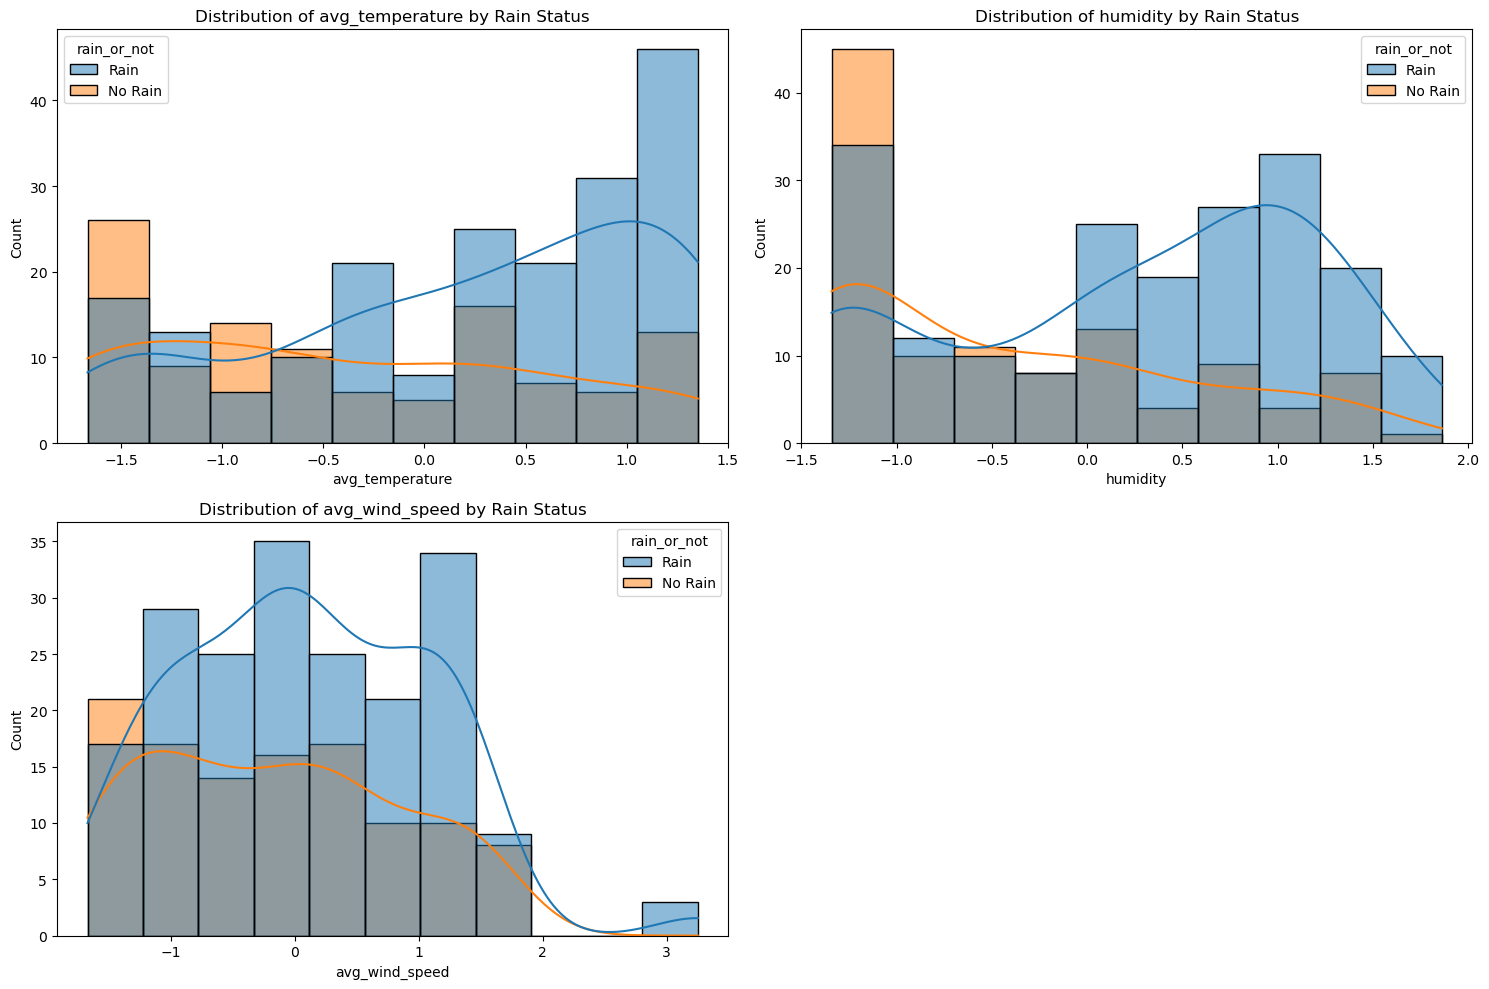

In [136]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(feature_columns[:3]):  # Using only the original features
    plt.subplot(2, 2, i+1)
    sns.histplot(data=weather, x=col, hue='rain_or_not', kde=True)
    plt.title(f'Distribution of {col} by Rain Status')
plt.tight_layout()
plt.show()

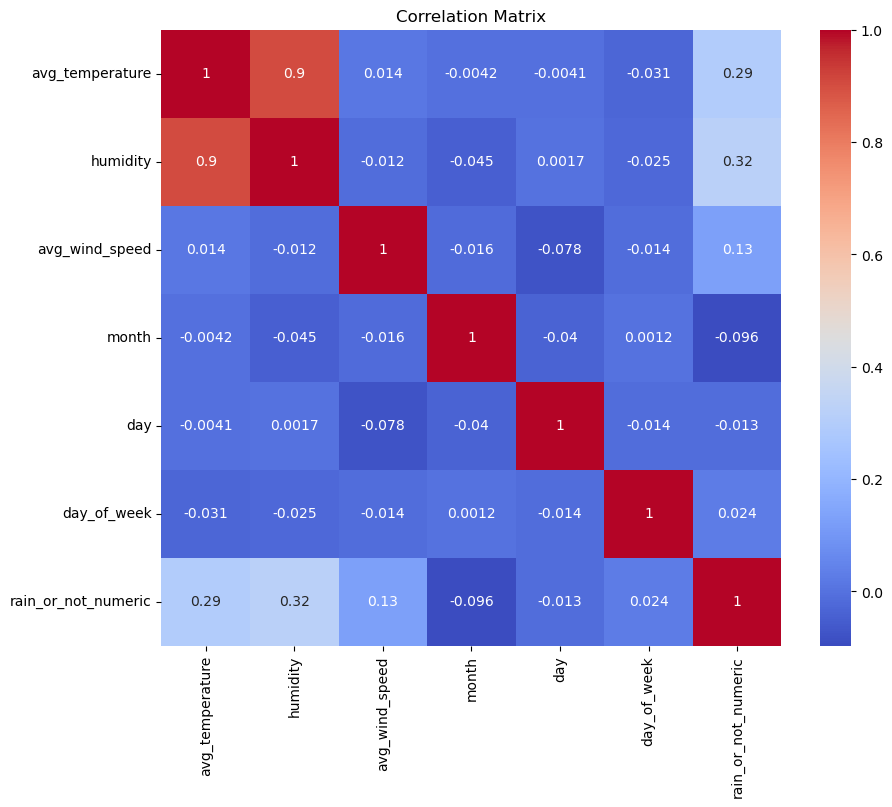

In [137]:
plt.figure(figsize=(10, 8))
correlation = weather[feature_columns + ['rain_or_not_numeric']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

<Figure size 1500x1000 with 0 Axes>

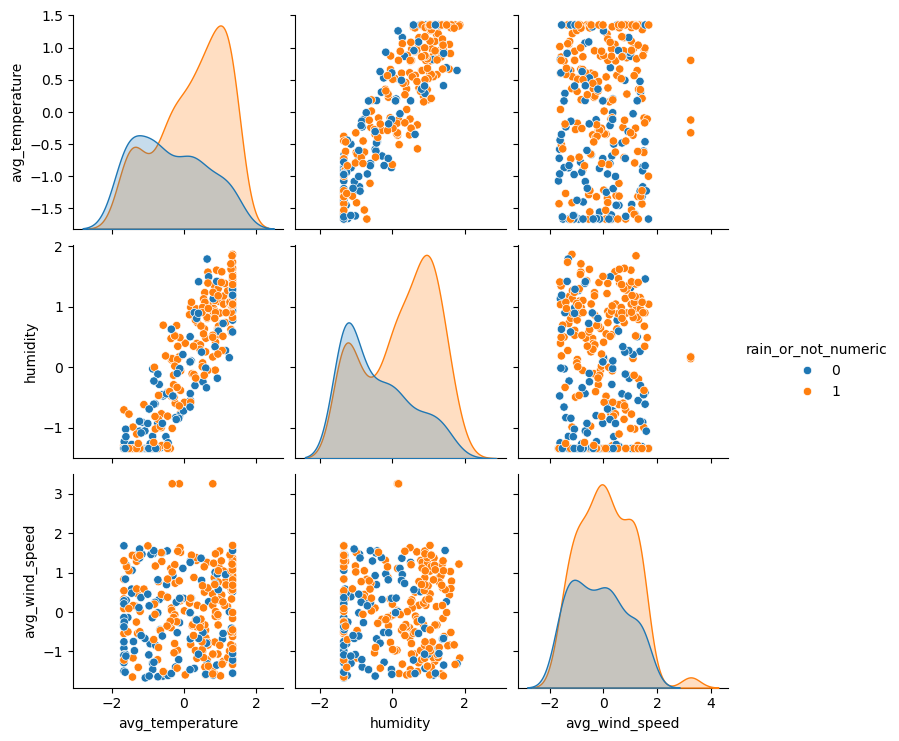

In [138]:
plt.figure(figsize=(15, 10))
sns.pairplot(weather[feature_columns[:3] + ['rain_or_not_numeric']], hue='rain_or_not_numeric')
plt.show()

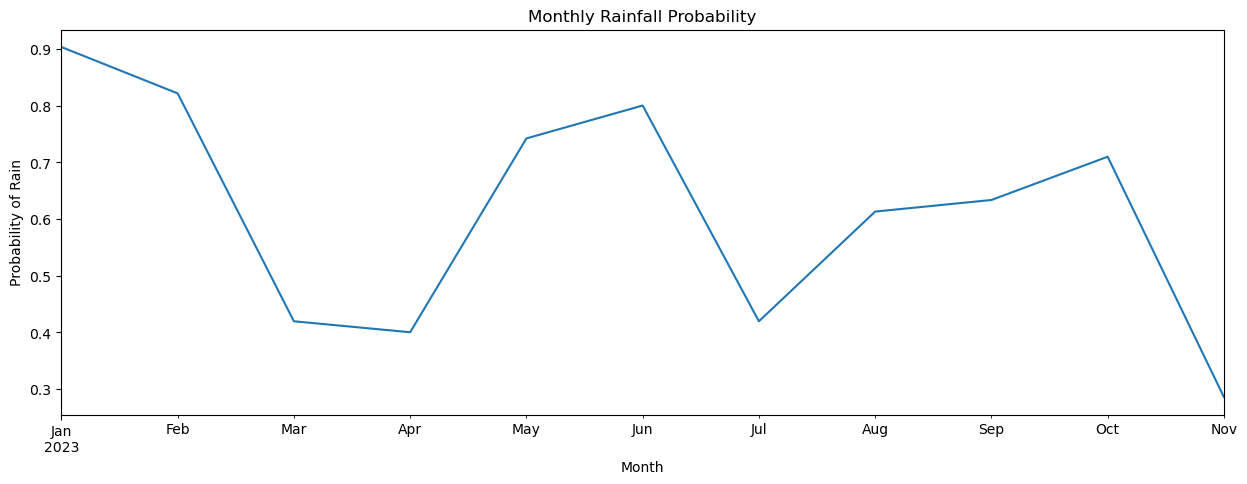

In [139]:
plt.figure(figsize=(15, 5))
df_original = weather.copy()  # Create a copy with the original unscaled values
df_original['month_year'] = df_original['date'].dt.to_period('M')
df_original['rain_or_not_numeric'] = df_original['rain_or_not'].apply(lambda x: 1 if x == 'Rain' else 0)
monthly_rain = df_original.groupby('month_year')['rain_or_not_numeric'].mean()
monthly_rain.plot()
plt.title('Monthly Rainfall Probability')
plt.ylabel('Probability of Rain')
plt.xlabel('Month')
plt.show()

<Figure size 1500x500 with 0 Axes>

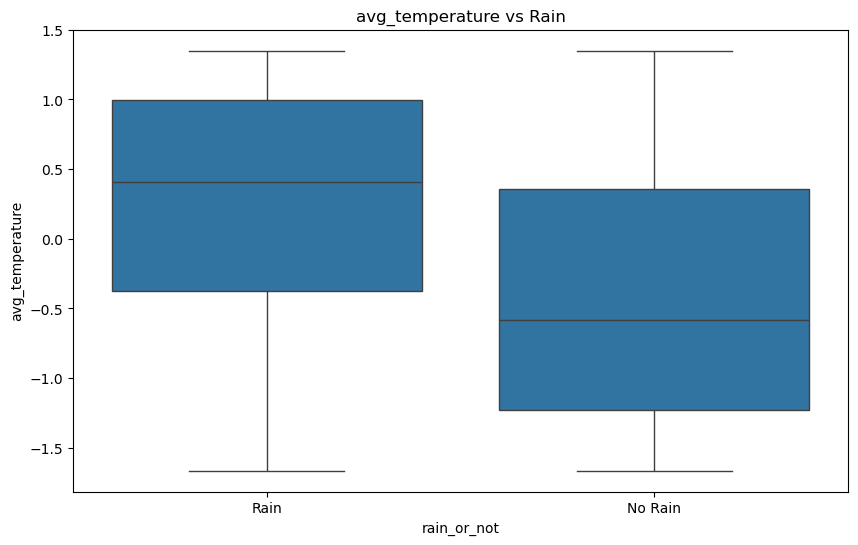

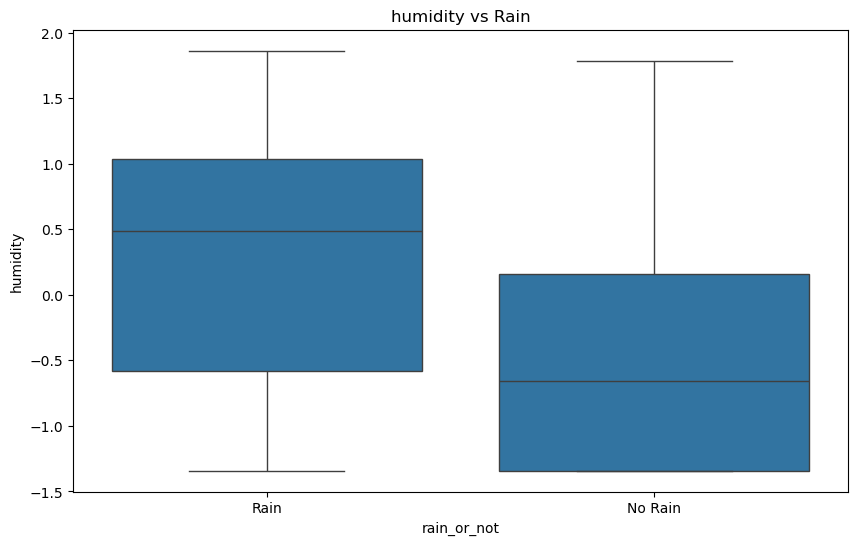

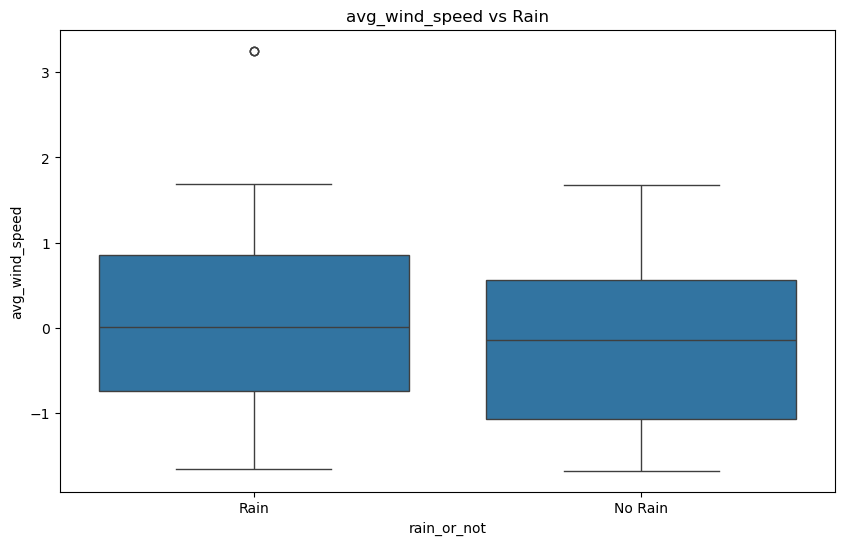

In [140]:
plt.figure(figsize=(15, 5))
for col in feature_columns[:3]:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='rain_or_not', y=col, data=df_original)
    plt.title(f'{col} vs Rain')
    plt.show()

3) Model Training and Evalution

In [141]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

y_train_numeric = y_train.apply(lambda x: 1 if x == 'Rain' else 0)
y_test_numeric = y_test.apply(lambda x: 1 if x == 'Rain' else 0)



In [142]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Print results
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    
    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:')
    print(cm)
    
    # Print classification report
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    return model, accuracy, precision, recall, f1, roc_auc


In [143]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}


Evaluating Logistic Regression:
Accuracy: 0.6349
Precision: 0.6889
Recall: 0.7750
F1 Score: 0.7294
ROC AUC: 0.6967
Confusion Matrix:
[[ 9 14]
 [ 9 31]]
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.39      0.44        23
           1       0.69      0.78      0.73        40

    accuracy                           0.63        63
   macro avg       0.59      0.58      0.58        63
weighted avg       0.62      0.63      0.62        63



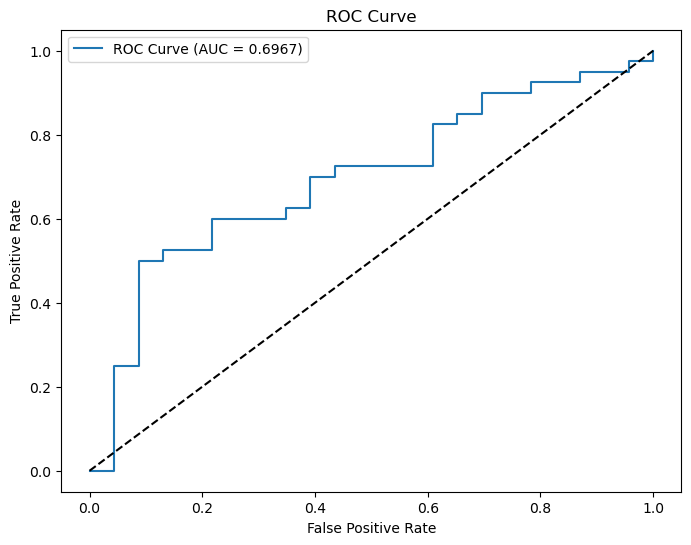


Evaluating Decision Tree:
Accuracy: 0.6667
Precision: 0.7111
Recall: 0.8000
F1 Score: 0.7529
ROC AUC: 0.6174
Confusion Matrix:
[[10 13]
 [ 8 32]]
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.43      0.49        23
           1       0.71      0.80      0.75        40

    accuracy                           0.67        63
   macro avg       0.63      0.62      0.62        63
weighted avg       0.65      0.67      0.66        63



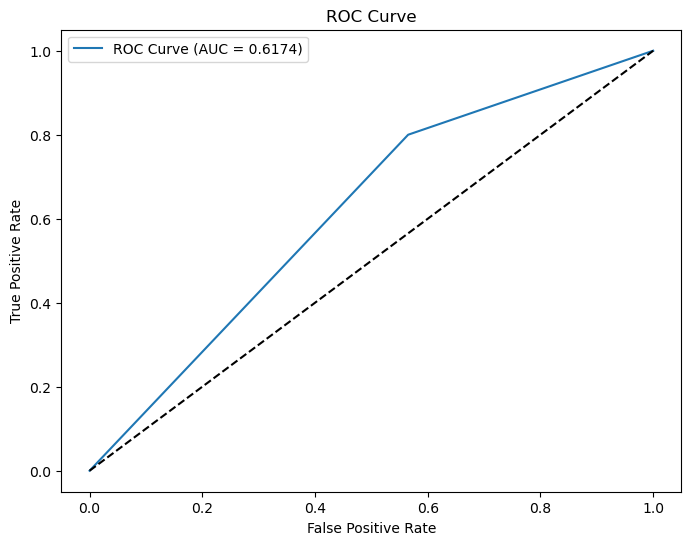


Evaluating Random Forest:
Accuracy: 0.6667
Precision: 0.6939
Recall: 0.8500
F1 Score: 0.7640
ROC AUC: 0.6446
Confusion Matrix:
[[ 8 15]
 [ 6 34]]
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.35      0.43        23
           1       0.69      0.85      0.76        40

    accuracy                           0.67        63
   macro avg       0.63      0.60      0.60        63
weighted avg       0.65      0.67      0.64        63



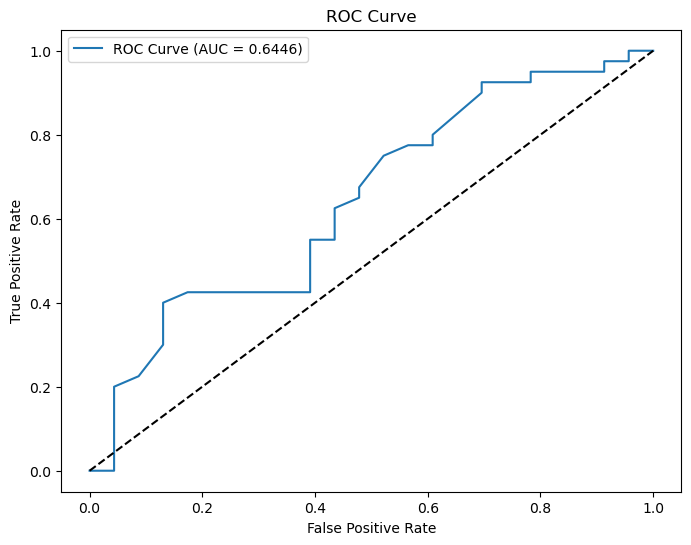


Evaluating Gradient Boosting:
Accuracy: 0.6190
Precision: 0.6667
Recall: 0.8000
F1 Score: 0.7273
ROC AUC: 0.5772
Confusion Matrix:
[[ 7 16]
 [ 8 32]]
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.30      0.37        23
           1       0.67      0.80      0.73        40

    accuracy                           0.62        63
   macro avg       0.57      0.55      0.55        63
weighted avg       0.59      0.62      0.60        63



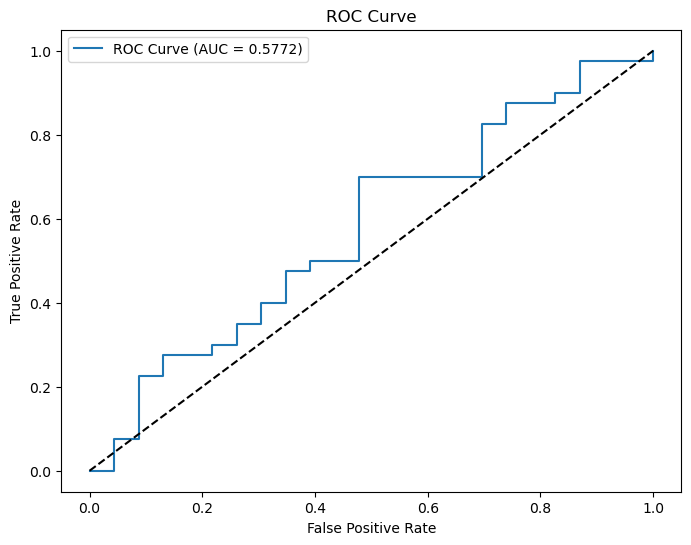

In [144]:
results = {}
for name, model in models.items():
    print(f"\nEvaluating {name}:")
    model_result = evaluate_model(model, X_train, X_test, y_train_numeric, y_test_numeric)
    results[name] = model_result

In [145]:
model_comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model][1] for model in results],
    'Precision': [results[model][2] for model in results],
    'Recall': [results[model][3] for model in results],
    'F1 Score': [results[model][4] for model in results],
    'ROC AUC': [results[model][5] for model in results]
})

In [146]:
print("\nModel Comparison:")
print(model_comparison.sort_values('F1 Score', ascending=False))


Model Comparison:
                 Model  Accuracy  Precision  Recall  F1 Score   ROC AUC
2        Random Forest  0.666667   0.693878   0.850  0.764045  0.644565
1        Decision Tree  0.666667   0.711111   0.800  0.752941  0.617391
0  Logistic Regression  0.634921   0.688889   0.775  0.729412  0.696739
3    Gradient Boosting  0.619048   0.666667   0.800  0.727273  0.577174


4) Hyperparameter Tuning and Feature Engineering

we choosed random forest

In [147]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel

In [148]:
best_model = results['Random Forest'][0]
feature_importances = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importances:")
print(feature_importances)

Feature Importances:
           Feature  Importance
1         humidity    0.227689
0  avg_temperature    0.215013
2   avg_wind_speed    0.185032
4              day    0.161284
3            month    0.112677
5      day_of_week    0.098305


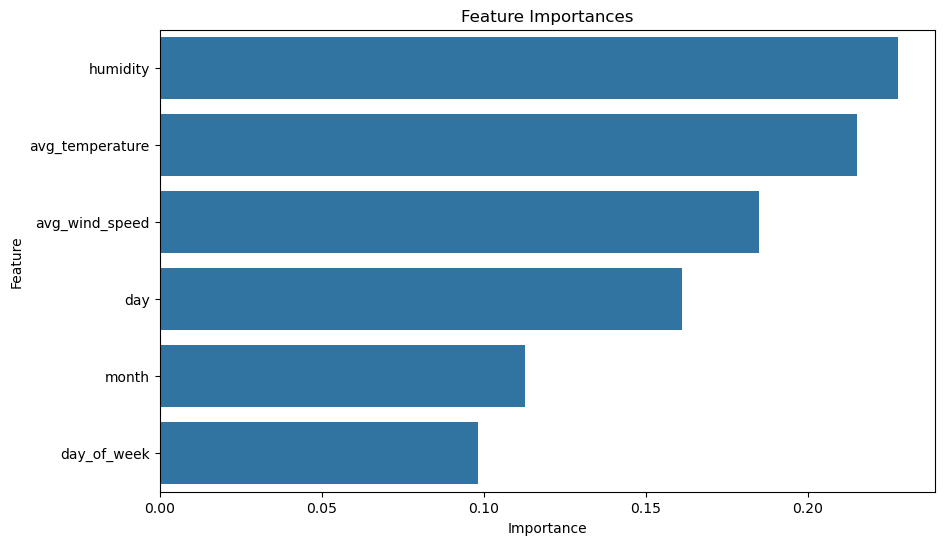

In [149]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()

Hyperparameter tuning with RandomizedSearchCV

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}

Evaluating Tuned Random Forest:
Accuracy: 0.6667
Precision: 0.6863
Recall: 0.8750
F1 Score: 0.7692
ROC AUC: 0.5978
Confusion Matrix:
[[ 7 16]
 [ 5 35]]
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.30      0.40        23
           1       0.69      0.88      0.77        40

    accuracy                           0.67        63
   macro avg       0.63      0.59      0.58        63
weighted avg       0.65      0.67      0.63        63



c:\Users\ROG STRIX\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
55 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
19 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ROG STRIX\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ROG STRIX\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\ROG STRIX\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\ROG STRIX\anacond

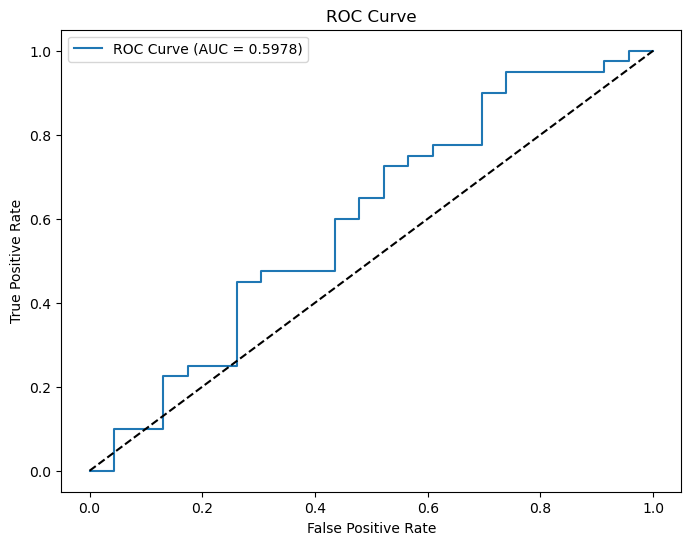

Selected Features: ['avg_temperature', 'humidity', 'avg_wind_speed']

Evaluating Random Forest with Selected Features:
Accuracy: 0.6508
Precision: 0.6875
Recall: 0.8250
F1 Score: 0.7500
ROC AUC: 0.6120
Confusion Matrix:
[[ 8 15]
 [ 7 33]]
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.35      0.42        23
           1       0.69      0.82      0.75        40

    accuracy                           0.65        63
   macro avg       0.61      0.59      0.59        63
weighted avg       0.63      0.65      0.63        63



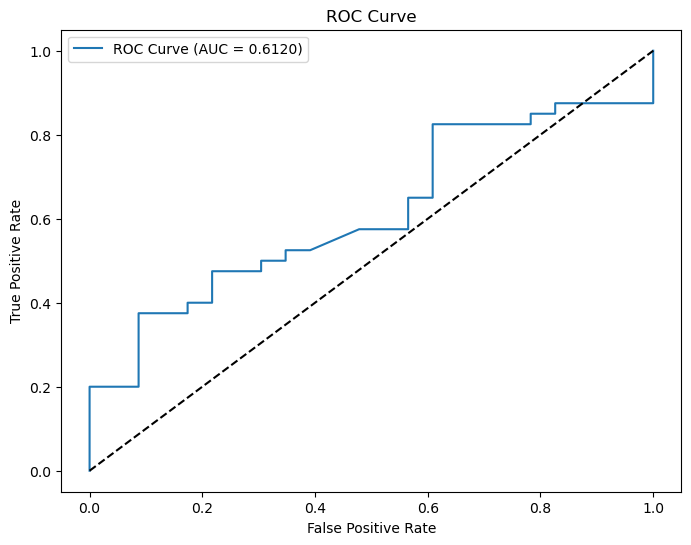

In [150]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    scoring='f1'
)

rf_random.fit(X_train, y_train_numeric)
print(f'Best Parameters: {rf_random.best_params_}')

# Evaluate the tuned model
tuned_rf = rf_random.best_estimator_
print("\nEvaluating Tuned Random Forest:")
tuned_results = evaluate_model(tuned_rf, X_train, X_test, y_train_numeric, y_test_numeric)

# Feature selection based on importance
selector = SelectFromModel(tuned_rf, threshold='median')
X_train_selected = selector.fit_transform(X_train, y_train_numeric)
X_test_selected = selector.transform(X_test)

# Check which features were selected
selected_features = [feature_columns[i] for i in range(len(feature_columns)) if selector.get_support()[i]]
print(f'Selected Features: {selected_features}')

# Train and evaluate model with selected features
print("\nEvaluating Random Forest with Selected Features:")
rf_selected = RandomForestClassifier(random_state=42, **rf_random.best_params_)
selected_results = evaluate_model(rf_selected, X_train_selected, X_test_selected, y_train_numeric, y_test_numeric)

In [151]:
"""from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_auc_score

# Create polynomial features (degree 2)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train a new Logistic Regression model on the polynomial features
lr_poly = LogisticRegression()
lr_poly.fit(X_train_poly, y_train)

#tuned_pr = lr_poly.best_estimator_
# Predict and evaluate
y_pred_poly = lr_poly.predict(X_test_poly)
rain_prob = lr_poly.predict_proba(X_test_poly)[:, 1]
roc_score = roc_auc_score(y_test, rain_prob)
print(f"AUC-ROC Score: {roc_score:.2f}")
print("Polynomial Features Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_poly))
print(classification_report(y_test, y_pred_poly))
print(classification_report(y_test, y_pred_poly))"""

"""rain_prob"""




'rain_prob'

5) Final Model for Prediction with Probabilities

In [152]:
def predict_rain_probability(model, future_data):
    # Scale the future data using the same scaler
    future_data_scaled = scaler.transform(future_data)
    
    # Get probability predictions
    probabilities = model.predict_proba(future_data_scaled)[:, 1]
    
    return probabilities

In [153]:
import datetime

today = datetime.datetime.now()
future_dates = [today + datetime.timedelta(days=i) for i in range(1, 22)]

# Create a dataframe with example future weather data
# This is where you would use real forecast data
future_df = pd.DataFrame({
    'date': future_dates,
    'avg_temperature': np.random.normal(20, 5, 21),  # Example values
    'humidity': np.random.normal(70, 10, 21),        # Example values
    'avg_wind_speed': np.random.normal(15, 5, 21)    # Example values
})

In [154]:
future_df['month'] = future_df['date'].dt.month
future_df['day'] = future_df['date'].dt.day
future_df['day_of_week'] = future_df['date'].dt.dayofweek


#future_df['temp_rolling_3'] = future_df['avg_temperature'].rolling(window=3, min_periods=1).mean()
#future_df['humidity_rolling_3'] = future_df['humidity'].rolling(window=3, min_periods=1).mean()
#future_df['wind_rolling_3'] = future_df['avg_wind_speed'].rolling(window=3, min_periods=1).mean()

In [155]:
#future_features = future_df[feature_columns].values



In [156]:
# Scale future features
future_features_scaled = scaler.transform(future_features)

# Transform with PolynomialFeatures
#future_features_poly = poly.transform(future_features_scaled)

# Get rain probabilities (class 1)
#rain_probabilities = lr_poly.predict_proba(future_features_poly)[:, 1]

# Print the raw probabilities
#print(rain_probabilities)


c:\Users\ROG STRIX\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [157]:
#prediction_df = pd.DataFrame({
    #'date': future_dates,
    #'rain_probability': rain_probabilities  # Extract the second column
#})

In [158]:
#print("Rainfall Probability Predictions for the Next 21 Days:")
#print(prediction_df)

In [159]:
#plt.figure(figsize=(12, 6))
#plt.bar(prediction_df['date'], prediction_df['rain_probability'])
#plt.axhline(y=0.5, color='r', linestyle='--', label='50% Threshold')
#plt.xlabel('Date')
#plt.ylabel('Probability of Rain')
#plt.title('Rain Forecast for the Next 21 Days')
#plt.xticks(rotation=45)
#plt.tight_layout()
#plt.legend()
#plt.show()

Rainfall Probability Predictions for the Next 21 Days:
                         date  rain_probability
0  2025-03-09 18:17:26.554663          0.558095
1  2025-03-10 18:17:26.554663          0.721619
2  2025-03-11 18:17:26.554663          0.705381
3  2025-03-12 18:17:26.554663          0.652143
4  2025-03-13 18:17:26.554663          0.879810
5  2025-03-14 18:17:26.554663          0.608619
6  2025-03-15 18:17:26.554663          0.582000
7  2025-03-16 18:17:26.554663          0.525429
8  2025-03-17 18:17:26.554663          0.660143
9  2025-03-18 18:17:26.554663          0.560976
10 2025-03-19 18:17:26.554663          0.597786
11 2025-03-20 18:17:26.554663          0.557214
12 2025-03-21 18:17:26.554663          0.807762
13 2025-03-22 18:17:26.554663          0.679167
14 2025-03-23 18:17:26.554663          0.521095
15 2025-03-24 18:17:26.554663          0.536048
16 2025-03-25 18:17:26.554663          0.701143
17 2025-03-26 18:17:26.554663          0.453857
18 2025-03-27 18:17:26.554663    

c:\Users\ROG STRIX\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\ROG STRIX\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


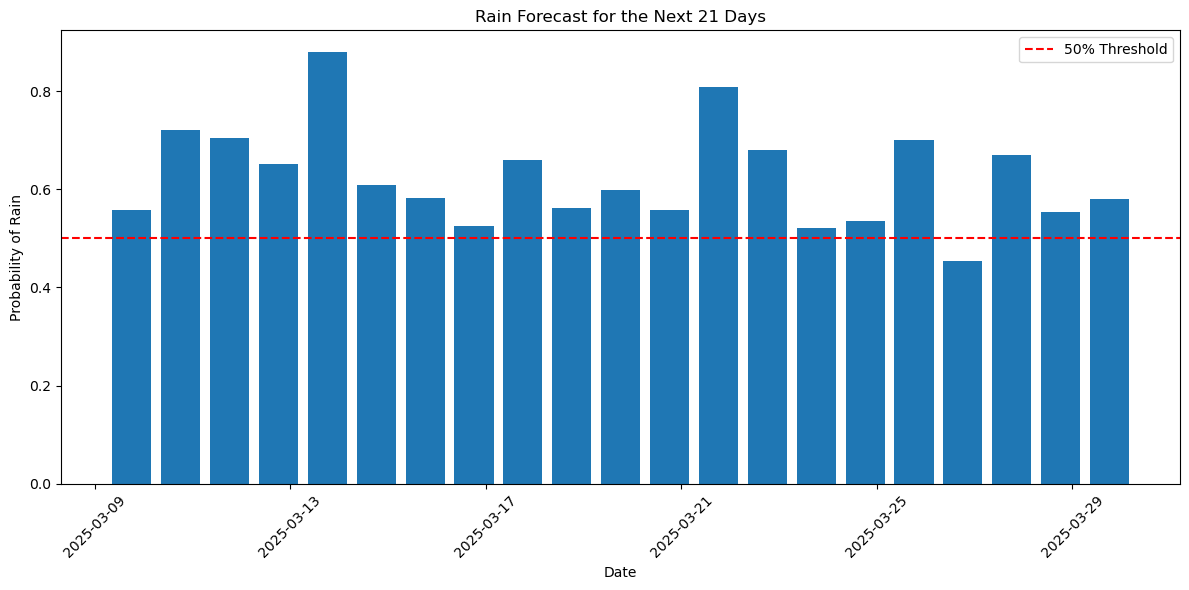

In [160]:
#future_features = future_df[feature_columns].values

# Predict rain probabilities
rain_probabilities = predict_rain_probability(tuned_rf, future_features)

# Create a prediction dataframe
prediction_df = pd.DataFrame({
    'date': future_dates,
    'rain_probability': rain_probabilities
})

print("Rainfall Probability Predictions for the Next 21 Days:")
print(prediction_df)

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.bar(prediction_df['date'], prediction_df['rain_probability'])
plt.axhline(y=0.5, color='r', linestyle='--', label='50% Threshold')
plt.xlabel('Date')
plt.ylabel('Probability of Rain')
plt.title('Rain Forecast for the Next 21 Days')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()